# **Exploratory Data Analysis**

In [1]:
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import yaml
from scipy import stats
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt

In [2]:
from dataframe_info import DataFrameInfo
from DataTransformation import DataTransform
from plot import Plotter
from plot import DataFrameTransform

## Accessing the Dataframe

In [3]:
table_of_loans = pd.read_csv('eda.csv')

## Investigating the current data

In [4]:
print(table_of_loans.head(10))
print(table_of_loans.tail(10))

         id  member_id  loan_amount  funded_amount  funded_amount_inv  \
0  38676116   41461848         8000         8000.0             8000.0   
1  38656203   41440010        13200        13200.0            13200.0   
2  38656154   41439961        16000        16000.0            16000.0   
3  38656128   41439934        15000        15000.0            15000.0   
4  38656121   41439927        15000        15000.0            15000.0   
5  38656111   41439917         2525         2525.0             2525.0   
6  38656110   41439916         6675         6675.0             6675.0   
7  38656067   41439872        26500        26500.0            26200.0   
8  38656063   41439868        10000        10000.0            10000.0   
9  38656052   41439857        10000            NaN            10000.0   

        term  int_rate  instalment grade sub_grade  ... recoveries  \
0  36 months      7.49      248.82     A        A4  ...        0.0   
1  36 months      6.99      407.52     A        A3  ... 

In [5]:
print(table_of_loans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

In [6]:
print(table_of_loans.describe())

                 id     member_id   loan_amount  funded_amount  \
count  5.423100e+04  5.423100e+04  54231.000000   51224.000000   
mean   7.621797e+06  8.655350e+06  13333.076100   13229.509117   
std    9.571362e+06  1.031281e+07   8082.196709    8019.017599   
min    5.552100e+04  7.069400e+04    500.000000     500.000000   
25%    7.594330e+05  9.587720e+05   7000.000000    7000.000000   
50%    7.084590e+06  8.709873e+06  12000.000000   12000.000000   
75%    8.860616e+06  1.052714e+07  18000.000000   18000.000000   
max    3.867612e+07  4.146185e+07  35000.000000   35000.000000   

       funded_amount_inv      int_rate    instalment    annual_inc  \
count       54231.000000  49062.000000  54231.000000  5.423100e+04   
mean        12952.622979     13.507328    400.013953  7.222085e+04   
std          8099.473527      4.392893    238.920012  5.158934e+04   
min             0.000000      5.420000     15.670000  3.300000e+03   
25%          6700.000000     10.370000    224.205000  4

In [7]:
print(f"std loan_amount = {table_of_loans['loan_amount'].std()}, mean loan_amount = {table_of_loans['loan_amount'].mean()}")
print(f"Max loan: {table_of_loans['loan_amount'].max()}, Min loan:{table_of_loans['loan_amount'].min()}")

std loan_amount = 8082.196709213126, mean loan_amount = 13333.076100385388
Max loan: 35000, Min loan:500


# Exploring the data

In [8]:
df_df = DataFrameInfo(table_of_loans)

In [9]:
print(df_df.check_column_datatypes())
print('')
df_df.num_of_nulls()

id                               int64
member_id                        int64
loan_amount                      int64
funded_amount                  float64
funded_amount_inv              float64
term                            object
int_rate                       float64
instalment                     float64
grade                           object
sub_grade                       object
employment_length               object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_date                      object
loan_status                     object
payment_plan                    object
purpose                         object
dti                            float64
delinq_2yrs                      int64
earliest_credit_line            object
inq_last_6mths                   int64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_accounts                    int64
total_accounts           

,column,count,% null count
0,id,54231,0.000000
1,member_id,54231,0.000000
2,loan_amount,54231,0.000000
3,funded_amount,51224,5.544799
4,funded_amount_inv,54231,0.000000
5,term,49459,8.799395
6,int_rate,49062,9.531449
7,instalment,54231,0.000000
8,grade,54231,0.000000
9,sub_grade,54231,0.000000


In [11]:
print(f"The no. of Unique Items in {df_df.count_unique_categories(['grade'])}")
print('')
print(df_df.extract_statistical_values(['loan_amount']))
print(' ')
df_df.shape_of_dataframe()

The no. of Unique Items in grade    7
dtype: int64

Statistics for Col: loan_amount
count    54231.000000
mean     13333.076100
std       8082.196709
min        500.000000
25%       7000.000000
50%      12000.000000
75%      18000.000000
max      35000.000000
Name: loan_amount, dtype: float64
 
Shape of DataFrame: [54231 rows x 43 columns]



# Transforming pt 1

### The below explains the transformation for the Transform code that follows:

- to_boolean: transforms 'n' to false and y to true in the payment plan column (prints [True] as the only unique value in the dataframe column)

- to_object: The columns in the to_object list created above are converted to objects as their numerical value doesn't impact the loan data information

- to_category: uses a list of columns and transforms them into catagories

- string_to_dates: Transforms the column string in the string_month_and_year list to a datetime format YearMonth

- extract_integer_from_string: extracts any intergers found in a string, allowing for analysis later on

- to_numerical_column: converts integers to numerical values (which includes all types of numeric data)

- drop_column: Uses the drop_cols list to remove columns from the data

- to_interger: Converts values to integers, can be be analysed as a whole number

- to_rounded_float: rounds float values to 2 d.p. (which is more accurate)

- save_transformed_data: saves a transformed version of the data

### Deciding what to drop
1. funded_amount is missing some data but contains the same data as funded_amount_inv, so we can drop it
1. out_prncp_inv contains the same data as out_prncp, so we can drop it
1. total_payment_inv contains the same data as total_payment, so we can drop it
1. application_type and policy_code are the same for everyone and doesn't provide us with much info


In [12]:
Transform = DataTransform(table_of_loans)

In [13]:
Transform.to_boolean('payment_plan')

to_object_columns = ['id', 'member_id', 'policy_code']
Transform.to_object(to_object_columns)

convert_categories = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'employment_length']
Transform.to_category(convert_categories)

string_month_and_year = ['last_credit_pull_date', 'next_payment_date', 'last_payment_date', 'earliest_credit_line', 'issue_date']
Transform.strings_to_dates(string_month_and_year)

string_numbers = ['term']
Transform.extract_integer_from_string(string_numbers)

numericals = ['term', 'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record']
Transform.to_numerical_column(numericals)

drop_cols = ['funded_amount', 'application_type', 'policy_code', 'out_prncp_inv', 'total_payment_inv']
Transform.drop_column(drop_cols)

int_numbers = ['loan_amount', 'funded_amount_inv', 'annual_inc', 'term', 'open_accounts', 'total_accounts', 'collections_12_mths_ex_med', 'mths_since_last_delinq', 'mths_since_last_major_derog']
Transform.to_interger(int_numbers)

Transform.to_rounded_float('collection_recovery_fee', 2)

Transform.save_full_data('full_loan_data.csv')

[ True]


# Transforming pt 2

In [14]:
table_of_loans = pd.read_csv('full_loan_data.csv')

In [15]:
df_cols = DataFrameTransform(table_of_loans)

In [16]:
plot = Plotter(table_of_loans)

#### Here we want to visualise the number of null values and the correct them via imputation or dropping. Then we can re-visualise the data.

In [17]:
df_cols.num_of_nulls()

,column,count,% null count
0,id,54231,0.000000
1,member_id,54231,0.000000
2,loan_amount,54231,0.000000
3,funded_amount_inv,54231,0.000000
4,term,54231,0.000000
5,int_rate,49062,9.531449
6,instalment,54231,0.000000
7,grade,54231,0.000000
8,sub_grade,54231,0.000000
9,employment_length,52113,3.905515


In [18]:
df_cols.impute_zeros(['employment_length'])
df_cols.impute_median(['int_rate'])
df_cols.drop_null_rows(['last_payment_date', 'last_credit_pull_date'])
df_cols.drop_column(['mths_since_last_delinq', 'next_payment_date', 'mths_since_last_record', 'mths_since_last_major_derog'])

- Missing values in employment_length can be assumed to be unemployment

- Missing values in int_rate may be needed so we impute to median values as it is less affected by outliers than mean

- Data missing in last_payment_date and last_credit_pull_date is too small to impact much, so we remove the rows

- Data missing from 57%-88%, so drop column (mths_since_last_delinq, next_payment_date, mths_since_last_record & mths_since_last_major_derog)


In [ ]:
plot.show_missing_nulls()

#### Save a version of data to use after the Outlier stage / Milestone 4 later on

In [19]:
df_cols.save_untransformed_data('untransformed_loan_data.csv')

In [20]:
# testing int_rate
int_rate_data = table_of_loans['int_rate']

# D’Agostino’s K^2 Test
stat, p = normaltest(int_rate_data, nan_policy='omit')
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1724.538, p=0.000


## Visualising the Data
#### This will allow us to loook for skews

The median of ['total_payment'] is 10123.08
The mean of ['total_payment'] is 12094.400013372735
Skew of ['total_payment'] column is 1.2698752968451772
Statistics=11271.968, p=0.000


/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


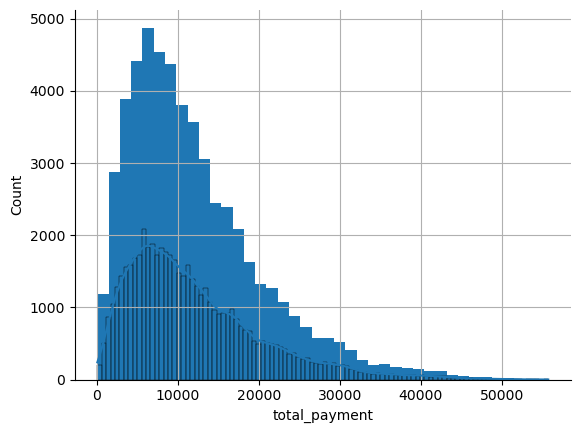

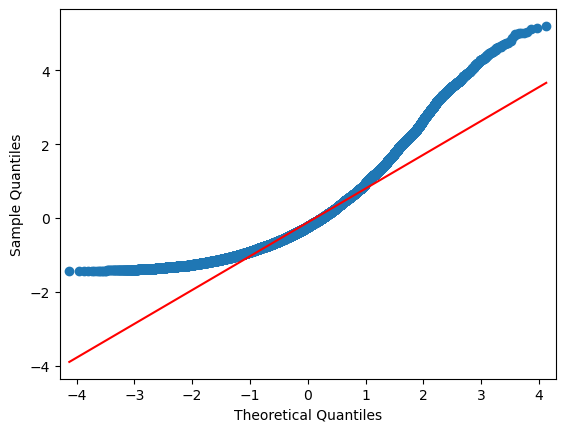

In [21]:
plot.multi_plot('total_payment')

The median of ['funded_amount_inv'] is 11325.0
The mean of ['funded_amount_inv'] is 12958.33842403649
Skew of ['funded_amount_inv'] column is 0.8133743608921553
Statistics=4673.099, p=0.000


/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


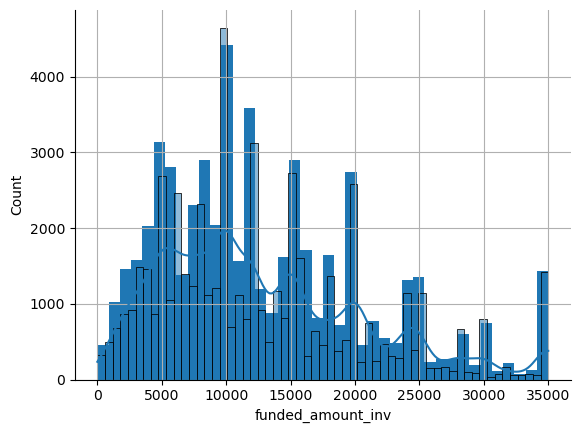

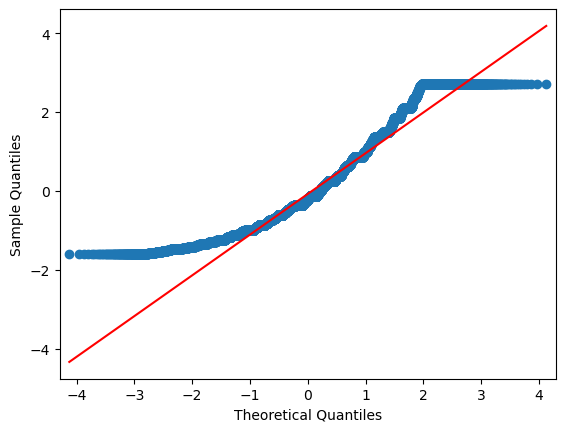

In [22]:
plot.multi_plot('funded_amount_inv')

The median of ['instalment'] is 347.15
The mean of ['instalment'] is 400.16004247382324
Skew of ['instalment'] column is 0.9965721690437305
Statistics=7272.241, p=0.000


/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


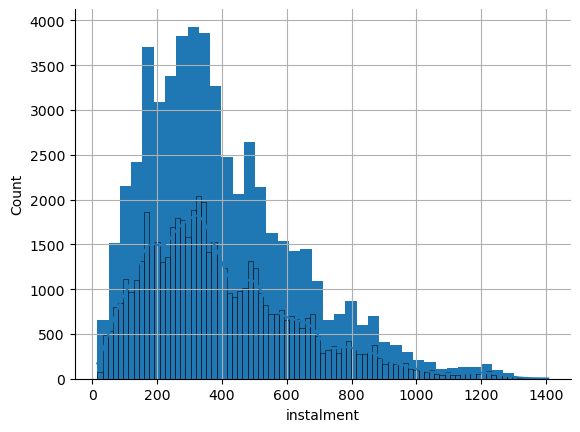

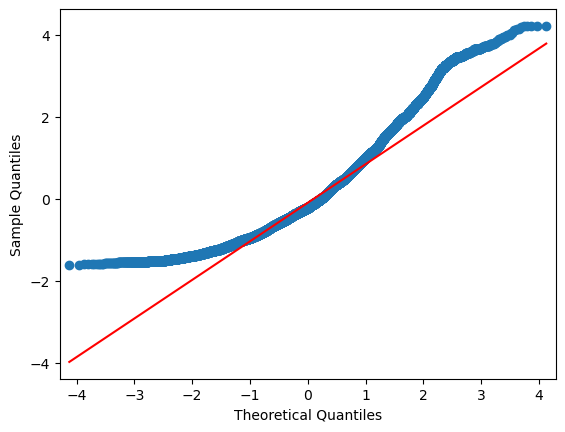

In [23]:
plot.multi_plot('instalment')

The median of ['loan_amount'] is 12000.0
The mean of ['loan_amount'] is 13338.588853391442
Skew of ['loan_amount'] column is 0.8049220181025606
Statistics=4576.014, p=0.000


/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


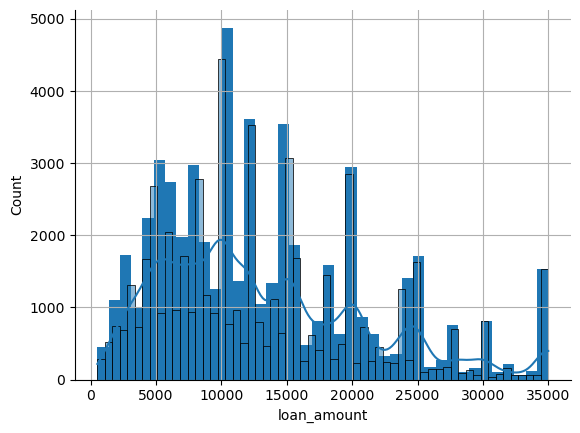

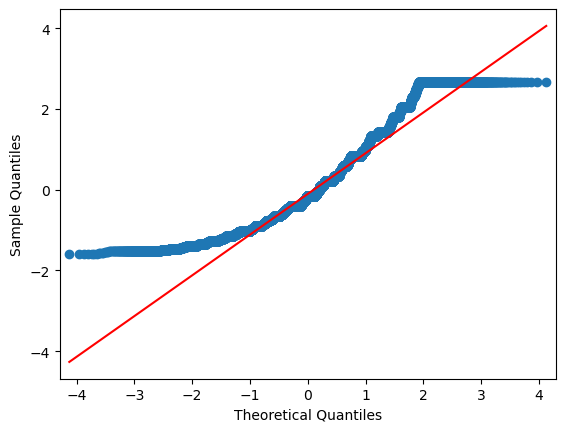

In [24]:
plot.multi_plot('loan_amount')

The median of ['int_rate'] is 13.16
The mean of ['int_rate'] is 13.472742885634617
Skew of ['int_rate'] column is 0.45661978102982004
Statistics=1724.538, p=0.000


/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


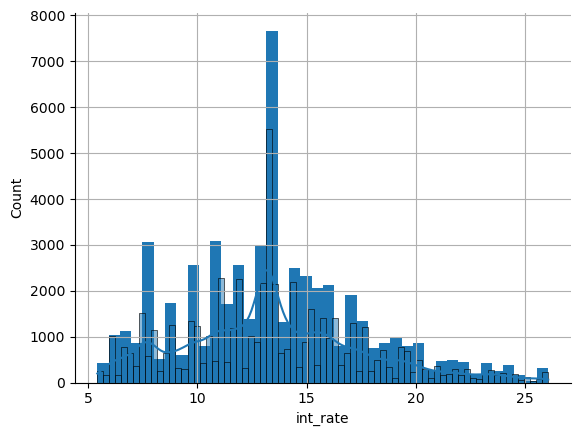

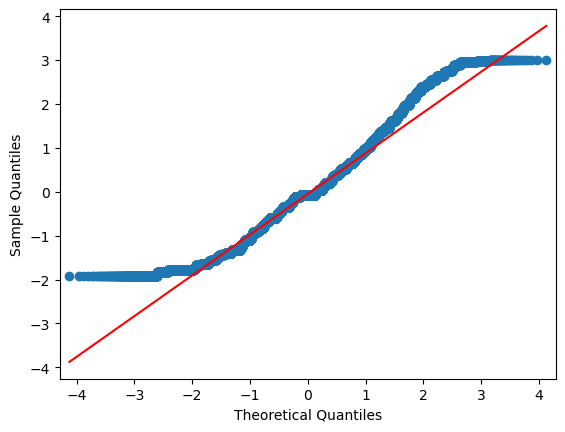

In [25]:
plot.multi_plot('int_rate')

- total_payments has a positive skew

- funded_amount_inv has normal distribution

- instalment has a positive skew but not far from a normal distribution

- loan_amount has a slight positive skew

- int_rate has normal distribution, mean and median are very similar (median imputation is valid)

## Skewness with and without transformations

##### Eventhough some columns have what looks like a normal distribution, by performing some transformations we can get them closer to a symetrical ditribution. For example:

1. int_rate Skewness: 0.45661978102982004, log transformation= -0.38 and with boxcox transformation = 0.46

1. total_accounts Skewness: 0.7790400286166349, log transformation= -0.68 and with boxcox transformation = 0.78

1. loan_amount Skewness: 0.8049220181025606, log transformation= -0.68 and boxcox transformation = 0.80

1. funded_amount_inv Skewness: 0.8133743608921553, log transformation= -3.33 and boxcox transformation = 0.81

1. dti Skewness: 0.18910057534680505, log transformation= -1.98 and boxcox transformation = 0.19

#### Completing these transformations for all the numerical columns allows us to decide which transformation creates a less skewed data set.

- The columns that were less skewed with Log transformations are 'annual_inc', 'total_accounts', 'open_accounts' and 'last_payment_amount'

- The columns that were less skewed with Boxcox transformations are 'loan_amount', 'instalment', 'int_rate', 'dti', 'funded_amount_inv' and 'total_payment'

/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

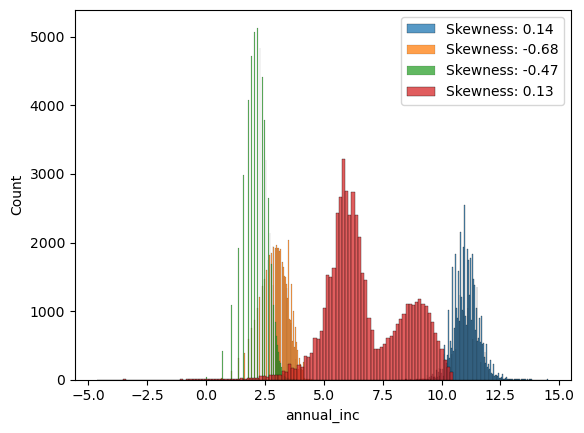

In [26]:
logt_cols = ['annual_inc', 'total_accounts', 'open_accounts', 'last_payment_amount']
df_cols.log_transform(logt_cols)

/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

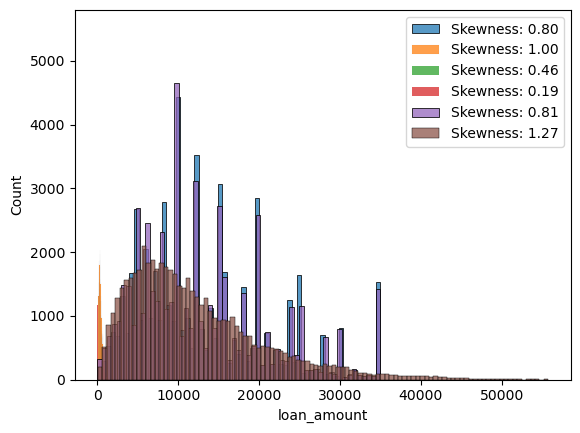

In [27]:
boxcox_cols = ['loan_amount', 'instalment', 'int_rate', 'dti', 'funded_amount_inv', 'total_payment']
df_cols.box_cox_transform(boxcox_cols)

In [28]:
df_cols.save_transformed_data('transformed_loan_data.csv')

#### Now that the transformed data has been saved, we can look into the outliers that remain within it

# Outlier Stage

In [29]:
transformed_loans = pd.read_csv('transformed_loan_data.csv')
df_cols = DataFrameTransform(transformed_loans)
plot = Plotter(transformed_loans)

#### The following will print density plots and a qqplot of all columns in 'numerical_cols', where some outliers can be seen

/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

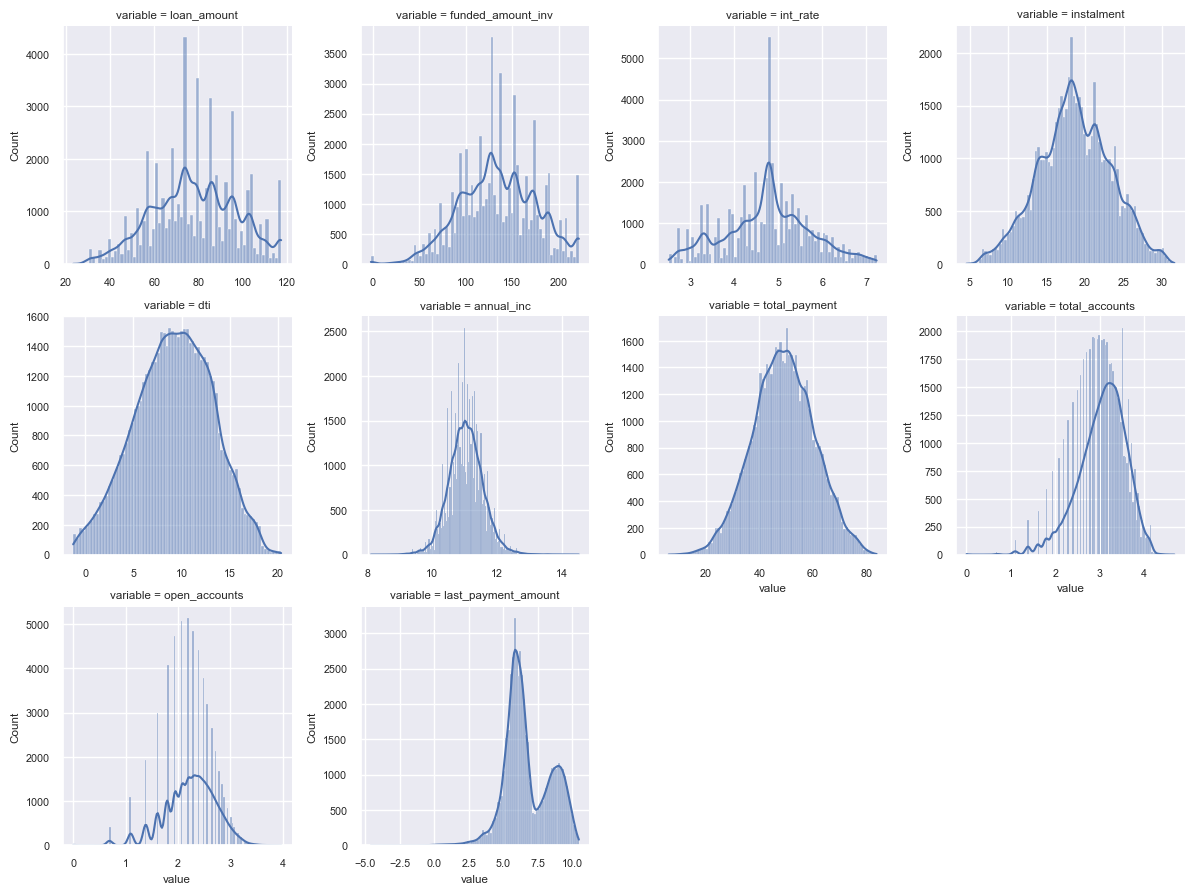

In [30]:
numerical_cols = ['loan_amount','funded_amount_inv', 'int_rate', 'instalment', 'dti', 'annual_inc', 'total_payment', 'total_accounts', 'open_accounts', 'last_payment_amount']
plot.multi_hist_plot(numerical_cols)

In [ ]:
plot.multi_qq_plot(numerical_cols)

#### Upon closer inspection, boxplots of columns show outliers present past the IQR

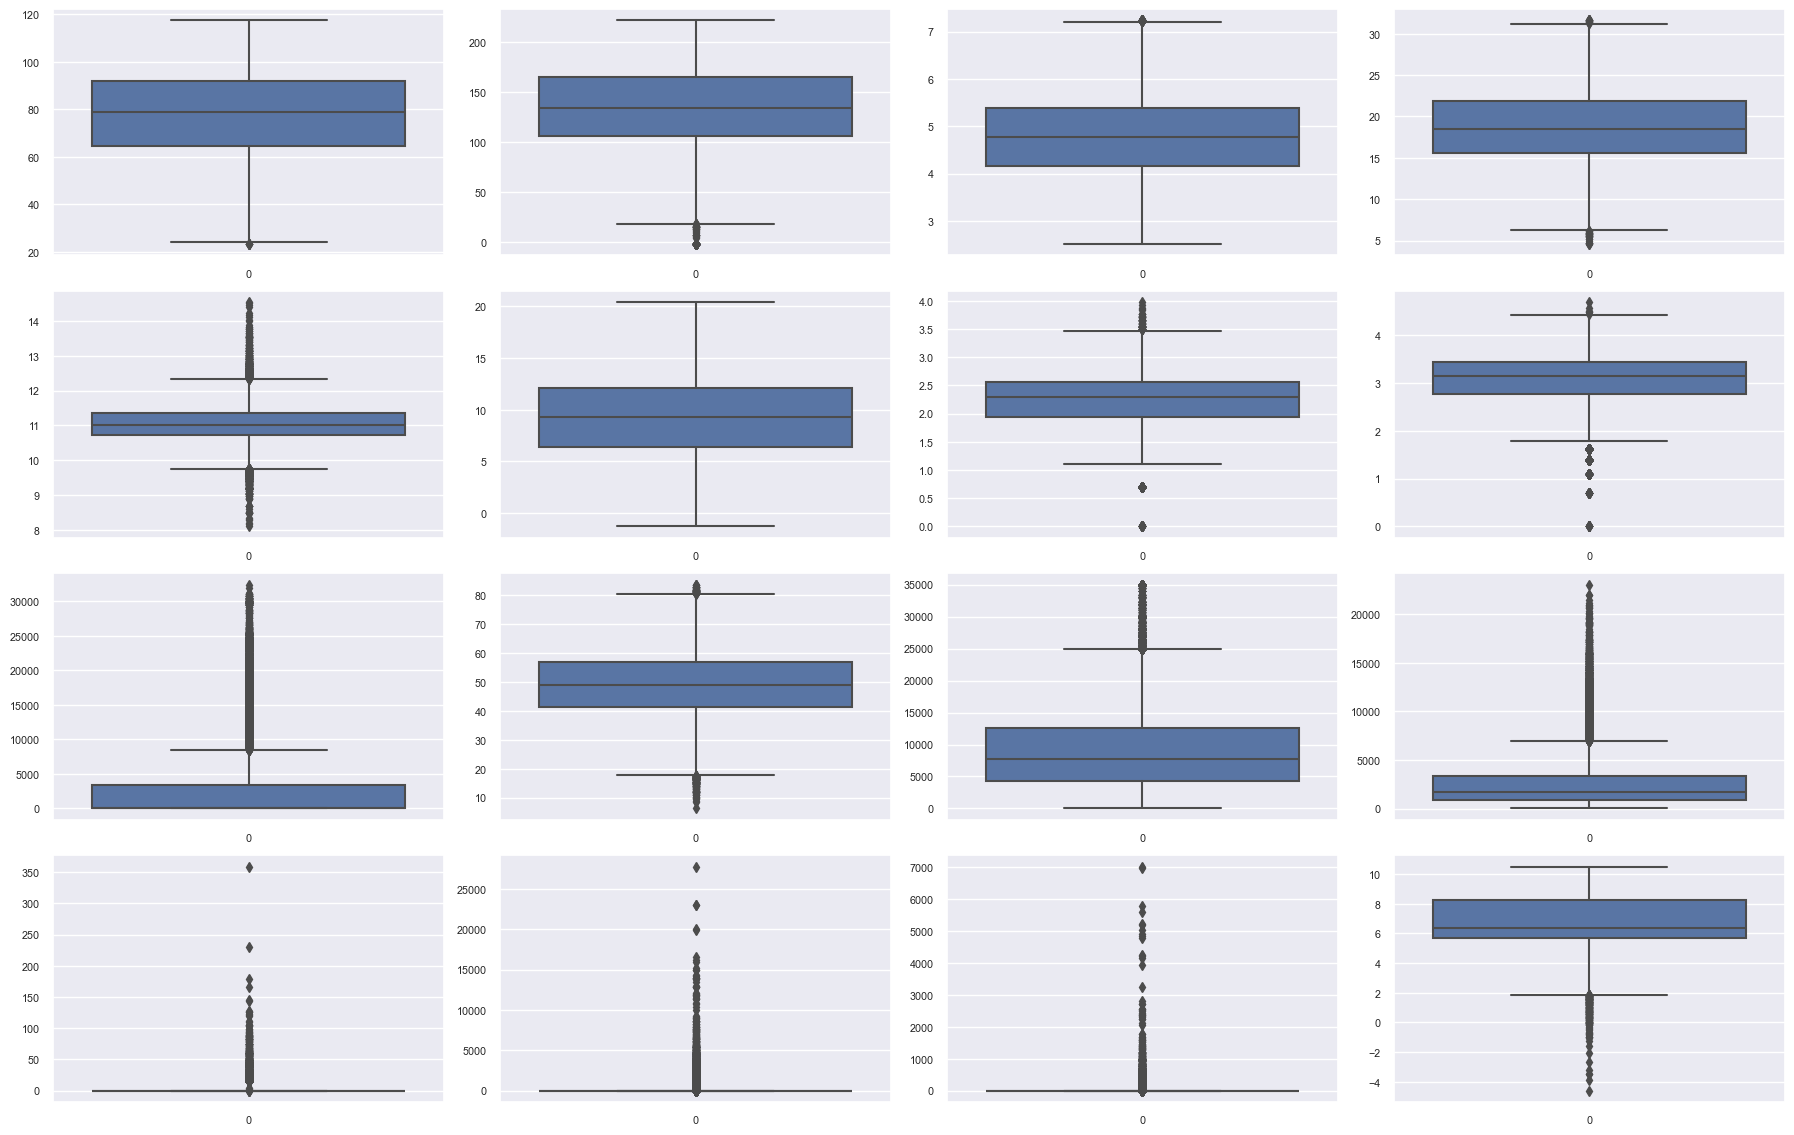

In [31]:
plot.show_outliers()

In [ ]:
plot.boxplot(numerical_cols)

##### Now to remove the outliers and re-visualise the boxplots

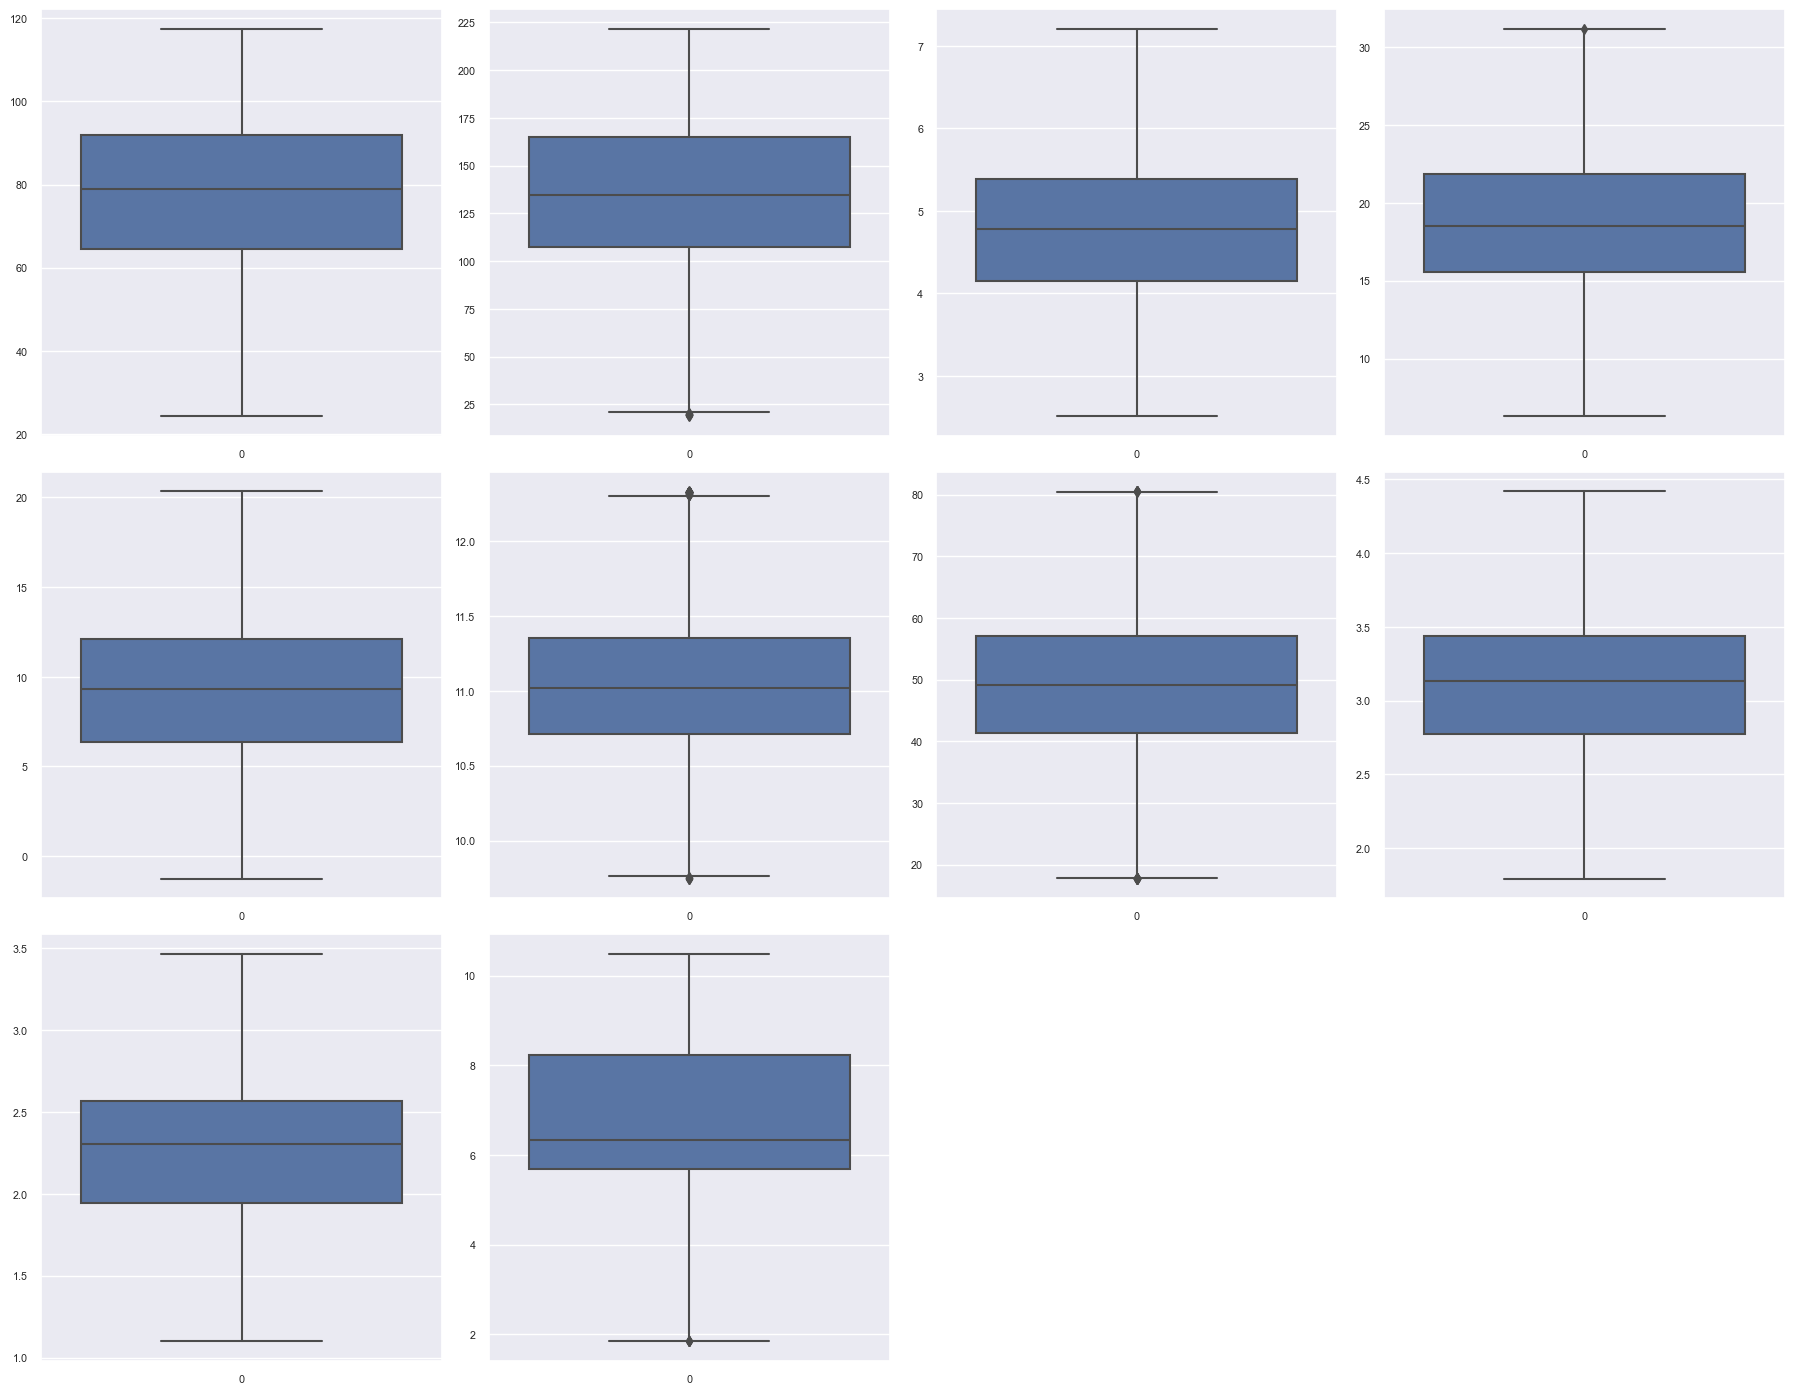

In [32]:
filtered_df = df_cols.remove_outliers_iqr_dataframe(column= numerical_cols, threshold=1.5)
plot.show_outliers_after_removal(dataframe=filtered_df, columns=numerical_cols)

#### Here we make a new variable in which we can use our previous classes for the filtered data

In [33]:
df_without_outliers = DataFrameTransform(filtered_df)
plot_without_outliers = Plotter(filtered_df)
Transform = DataTransform(filtered_df)

In [ ]:
plot_without_outliers.boxplot(numerical_cols)


/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

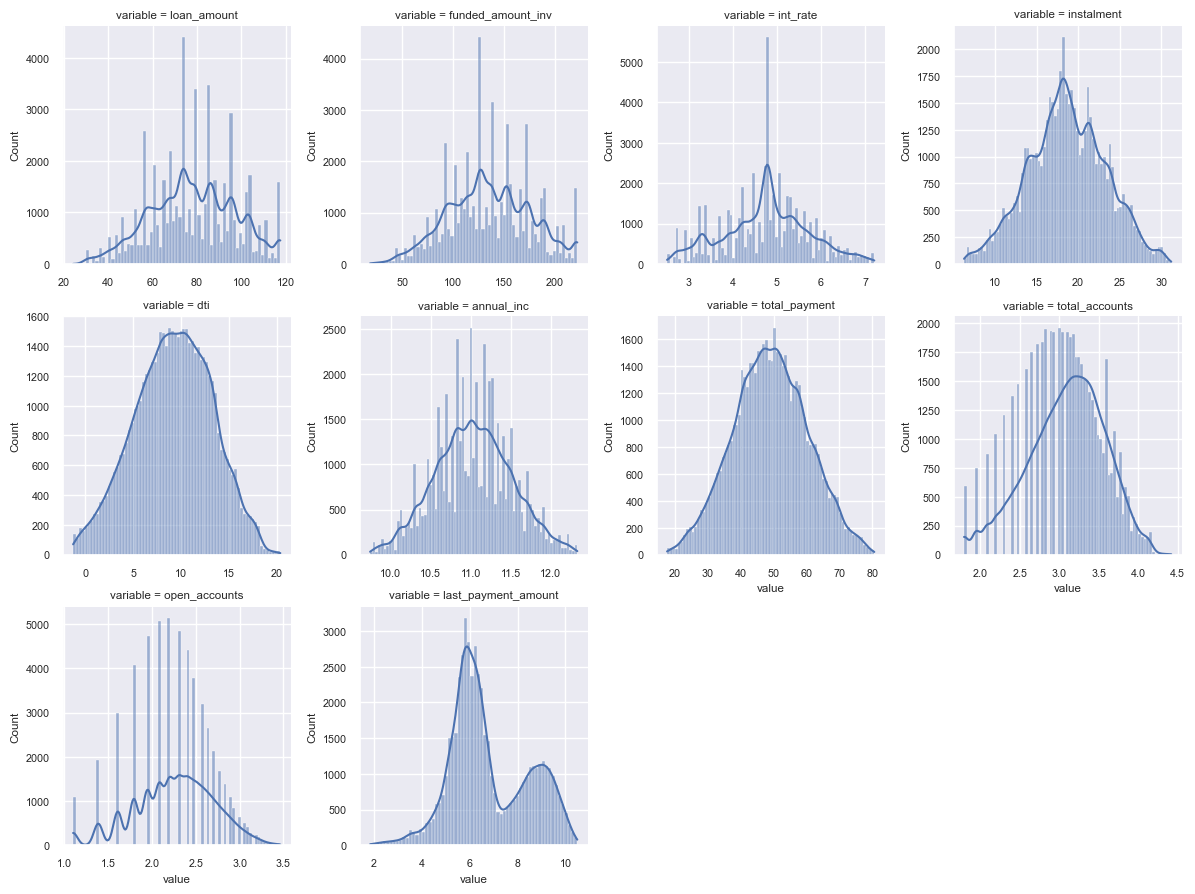

In [34]:
plot_without_outliers.multi_hist_plot(numerical_cols)

In [ ]:
plot_without_outliers.show_missing_nulls()
# removing the outliers has left NAN values, so we will either transform or remove the rows

In [35]:
df_without_outliers.num_of_nulls()
# values are all very low, impute with the mean!

,column,count,% null count
0,id,54151,0.000000
1,member_id,54151,0.000000
2,loan_amount,54145,0.011080
3,funded_amount_inv,53992,0.293623
4,term,54151,0.000000
5,int_rate,54107,0.081254
6,instalment,54111,0.073868
7,grade,54151,0.000000
8,sub_grade,54151,0.000000
9,employment_length,54151,0.000000


##### When imputing, if a column has noticeable outliers, the median is more robust and less influenced by extreme values.


In [36]:
to_be_median_imputed = ['loan_amount', 'funded_amount_inv',  'int_rate', 'instalment', 'annual_inc', 'open_accounts', 'total_accounts', 'total_payment', 'last_payment_amount']
df_without_outliers.impute_median(to_be_median_imputed)

In [ ]:
df_without_outliers.num_of_nulls()
plot_without_outliers.show_missing_nulls()

In [ ]:
plot_without_outliers.multi_qq_plot(numerical_cols)

#### Next is a corrolation matrix: checking for multicollinearity issues, overly corrolated columns will be dropped

/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


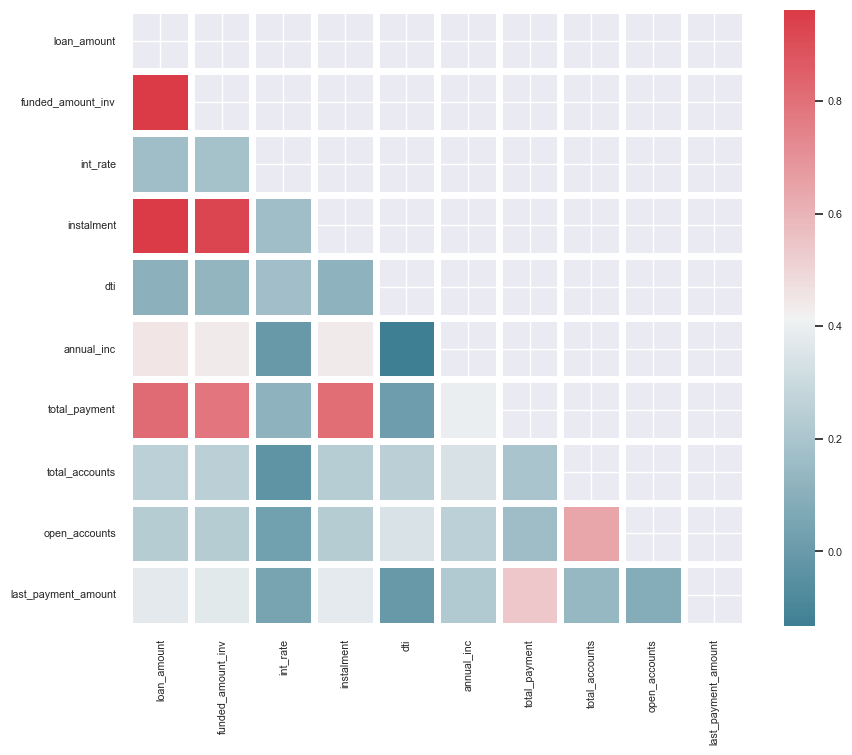

In [37]:
plot_without_outliers.heatmap(numerical_cols)

#### Threshold for highly correlated columns is 0.85

##### There is Multi-linearity between 'loan_amount', 'instalment' & 'funded_amount_inv'

- funded_amount_inv and loan_amount corrolation = 0.96
- instalmannt and loan_amount corrolation = 0.96
- instalmannt and funded_amount_inv corrolation = 0.93
- desptie columns being past the threshold, they're all important for the analysis stage, so we wont be dropping any of them!

#### total_payment is highly corrolated with loan_amount, funded_amount_inv and instalment too, but only at 0.81, 0.78 and 0.81 respectively
#### Therefore not passed the 0.85 threshold

In [38]:
df_cols.save_transformed_data('filtered_loan_data.csv')

# Analysis and Visualisation

## Current state of the Loans

##### We use the untransformed data here as we need the data unaffected by transformations for accurate results deeper insights and allow managment to make more informed decisions about which loans are a higher risk to the company.

In [39]:
filtered_df = pd.read_csv('untransformed_loan_data.csv')
df_without_outliers = DataFrameTransform(filtered_df)
plot_without_outliers = Plotter(filtered_df)
Transform = DataTransform(filtered_df)

##### Empty/NaN term values were originally imputed to 0, but upon more indepth analysis of the data the median is more appropriate as its less influenced by extreme values like 0

In [40]:
filtered_df['term'] = filtered_df['term'].replace(0, 36)

##### The following displays loan recovered (total_payment) againts invstor funding (funded_amount_inv) & total amount funded (loan_amount)


In [41]:
total_amount_funded = filtered_df['loan_amount'].sum()
print(f' Total loan amount funded is {total_amount_funded}')
invstor_funding = filtered_df['funded_amount_inv'].sum()
print(f' Total amount invested is {invstor_funding}')
total_payment_sum = filtered_df['total_payment'].sum()
print(f' Total payment recovered is {total_payment_sum}')

 Total loan amount funded is 722297925
 Total amount invested is 701706984
 Total payment recovered is 654923855.1241469


In [42]:
totals = round(filtered_df[['loan_amount', 'funded_amount_inv', 'total_payment']].sum(), 0)
totals

loan_amount          722297925.0
funded_amount_inv    701706984.0
total_payment        654923855.0
dtype: float64

In [43]:
print(f'Percentage of the loans recovered against the investor_funding is {(total_payment_sum/invstor_funding)*100}')
print(f'Percentage of the loans recovered against the total_amount_funded is {(total_payment_sum/total_amount_funded)*100}')

per_of__inv_loan_recovered = round((total_payment_sum/invstor_funding)*100, 2)
per_of__total_loan_recovered = round((total_payment_sum/total_amount_funded)*100, 2)
print(f' {per_of__inv_loan_recovered}%')
print(f' {per_of__total_loan_recovered}%')

Percentage of the loans recovered against the investor_funding is 93.33295379088702
Percentage of the loans recovered against the total_amount_funded is 90.67226035906816
 93.33%
 90.67%


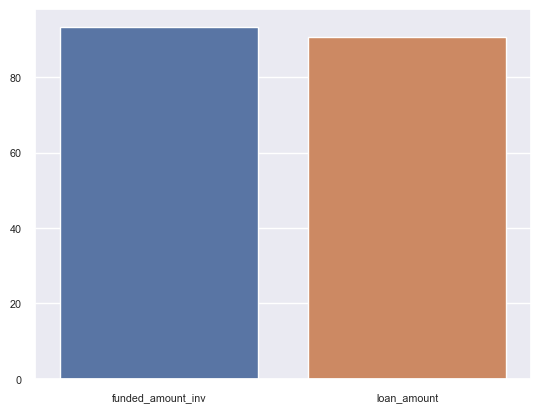

In [44]:
data = {
'funded_amount_inv': (filtered_df['total_payment'].sum()/invstor_funding)*100,
'loan_amount': (filtered_df['total_payment'].sum()/total_amount_funded)*100
}

plot_without_outliers.bar(data)

In [45]:
# Calculate percentage of investor funding recovered
pct_invetor_rec = round(100 * totals.total_payment/totals.funded_amount_inv, 2)
# Calculate percentage of funded amount recovered
pct_total_rec = round(100 * totals.total_payment/totals.loan_amount, 2) 

,Funding,Percent
0,Investor,93.33
1,Total,90.67


<Axes: xlabel='Funding', ylabel='% Recovered'>

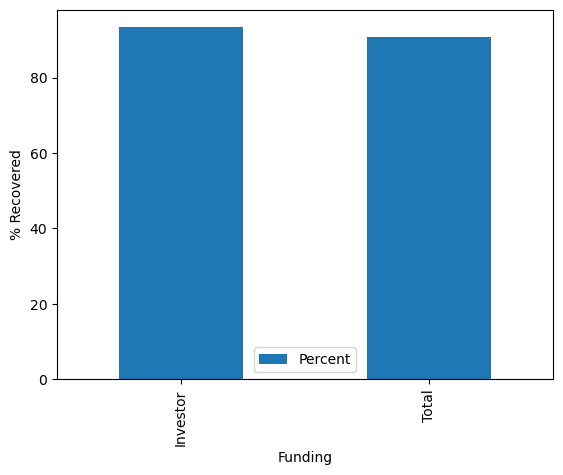

In [11]:
data = {'Funding': ['Investor', 'Total'],
            'Percent': [pct_invetor_rec, pct_total_rec]}

# Create a Pandas DataFrame
df = pd.DataFrame(data)
display(df)

df.plot(x="Funding", y="Percent", kind="bar", ylabel="% Recovered") 

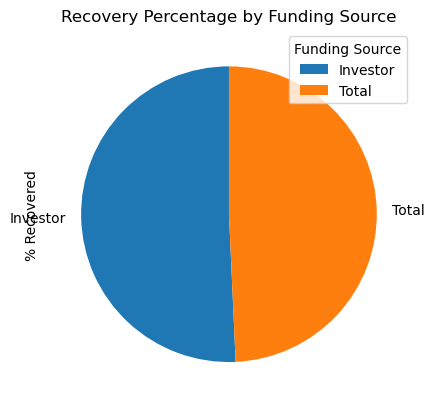

In [12]:
df.plot(y="Percent", kind="pie", ylabel="% Recovered", labels=df['Funding'], startangle=90, xlabel='Funding')
# Add a title and xlabel
plt.title("Recovery Percentage by Funding Source")
plt.legend(title="Funding Source")
# Display the chart
plt.show()

#### Remaining amount to be paid is calculated with the following code

In [46]:
remaining_amount = round(total_amount_funded - total_payment_sum, 2)
remaining_amount

67374069.88

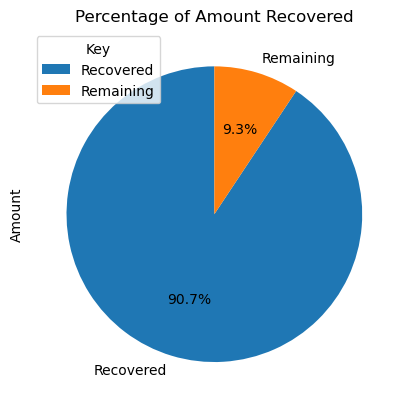

In [14]:
# Creating a DataFrame with the recovered and remaining amounts
data = {'Amount': [total_payment_sum, remaining_amount]}
df = pd.DataFrame(data, index=['Recovered', 'Remaining'])

# Plotting the pie chart
df.plot(y='Amount', kind='pie', autopct='%1.1f%%', startangle=90)
# Adding a title and legend title
plt.title("Percentage of Amount Recovered")
plt.legend(title="Key")
# Displaying the chart
plt.show()

#### 6 month projection is calculated by using the sum of the total_payment and the instalment and multiply this by the number of months to be predicted. 
#### Then divide this by the sum of the funded amount inv. Multiply by 100 to get this as a percentage

In [47]:
six_month_projection = round((filtered_df["total_payment"].sum()+(filtered_df["instalment"].sum()*6))/(filtered_df["funded_amount_inv"].sum())*100, 2)

,Funding,Percent
0,Total,111.86


<Axes: xlabel='Funding', ylabel='% Recovered'>

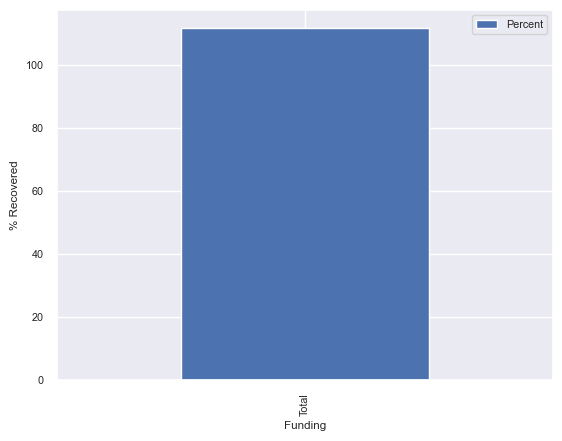

In [48]:
data = {'Funding': ['Total'],
        'Percent': [six_month_projection]}

# Create a Pandas DataFrame
df = pd.DataFrame(data)
display(df)

df.plot(x="Funding", y="Percent", kind="bar", ylabel="% Recovered") 

## Charged off loans

In [49]:
# Filter the DataFrame to include only charged off loans
charged_off_loans = filtered_df[filtered_df['loan_status'] == 'Charged Off']

# Calculate the percentage of charged off loans
charged_off_percentage = (charged_off_loans.shape[0] / filtered_df.shape[0]) * 100

# Calculate the total amount paid towards charged off loans
total_payment_charged_off = charged_off_loans['total_payment'].sum()

In [50]:
print(f"Percentage of charged off loans: {charged_off_percentage:.2f}%")
print(f"Total amount paid towards charged off loans: {total_payment_charged_off:.2f}")

Percentage of charged off loans: 10.16%
Total amount paid towards charged off loans: 37305414.56


In [51]:
charged_off_loans_loan_amount_sum = round(charged_off_loans['loan_amount'].sum(),2)
print(f' Total amount to be paid: {charged_off_loans_loan_amount_sum}')

charged_off_loans_total_payment_sum = round(charged_off_loans['total_payment'].sum(),2)
print(f' Total that has been paid: {charged_off_loans_total_payment_sum}')

charged_off_loans_loss = round(charged_off_loans_loan_amount_sum - charged_off_loans_total_payment_sum, 2)
print(f' Total that has been lost: {charged_off_loans_loss}')

 Total amount to be paid: 75700275
 Total that has been paid: 37305414.56
 Total that has been lost: 38394860.44


In [52]:
data = {'Paid': [charged_off_loans_total_payment_sum],
        'Loss': [charged_off_loans_loss]}

df = pd.DataFrame(data)
display(df)

,Paid,Loss
0,37305414.56,38394860.44


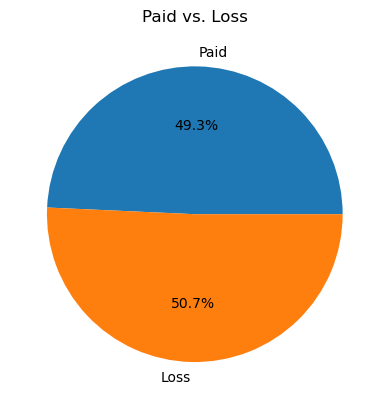

In [21]:
# Creating a pie chart
labels = ['Paid', 'Loss']
sizes = [charged_off_loans_total_payment_sum, charged_off_loans_loss]
colors = ['#1f77b4', '#ff7f0e']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
# Setting the title of the pie chart
plt.title('Paid vs. Loss')
# Displaying the pie chart
plt.show()

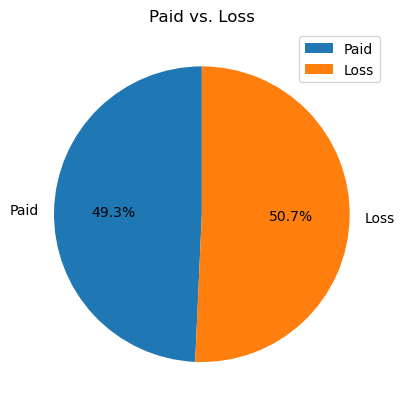

In [22]:
# Creating a pie chart
labels = ['Paid', 'Loss']
sizes = [charged_off_loans_total_payment_sum, charged_off_loans_loss]
colors = ['#1f77b4', '#ff7f0e']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
# Setting the title of the pie chart
plt.title('Paid vs. Loss')
# Adding a legend
plt.legend()
# Displaying the pie chart
plt.show()

In [53]:
filtered_df['num_of_payments_made'] = filtered_df['total_payment'] / filtered_df['instalment']
filtered_df['months_left_to_pay'] = filtered_df['term'] - filtered_df['num_of_payments_made']

## Risk loans

In [54]:
# Filtering the DataFrame to include only late loans
risk_loans = filtered_df[(filtered_df['loan_status'] == 'Late (31-120 days)') | (filtered_df['loan_status'] == 'Late (16-30 days)')]
# Calculating the percentage of risk loans
risk_percentage = round((risk_loans.shape[0] / filtered_df.shape[0]) * 100, 2)
# Calculating the total amount paid towards charged off loans
total_customers_in_risk_bracket = round(risk_loans.shape[0],0)
print(f"Percentage of risk loans: {risk_percentage}%")
print(f"Total number of customers in risk bracket: {total_customers_in_risk_bracket}")

Percentage of risk loans: 1.27%
Total number of customers in risk bracket: 686


In [55]:
risk_loans_loan_amount_sum = round(risk_loans['loan_amount'].sum(),2)
# print(f' Total amount to be paid: {risk_loans_loan_amount_sum}')
risk_loans_total_payment_sum = round(risk_loans['total_payment'].sum(),2)
# print(f' Total that has been paid: {risk_loans_total_payment_sum}')
risk_loans_loss = round(risk_loans_loan_amount_sum - risk_loans_total_payment_sum, 2)
print(f'Total still to be paid (exclusive of int_rate): {risk_loans_loss}')
# print(f'Percentage: {round((risk_loans_loss/risk_loans_loan_amount_sum)*100,2)}%')

Total still to be paid (exclusive of int_rate): 3408775.05


In [56]:
risk_amount_left_to_pay_ = risk_loans['months_left_to_pay'] * risk_loans['instalment']
projected_loss = round(risk_amount_left_to_pay_.sum(), 2)
print(f"Projected Loss if Switched to Charged Off: ${projected_loss}")

Projected Loss if Switched to Charged Off: $7316814.49


In [57]:
risk_charged_off_rev_pct = risk_percentage + charged_off_percentage 
print(f'Percentage of late and charged off revenue: {risk_charged_off_rev_pct:.2f}%')

Percentage of late and charged off revenue: 11.43%


##### Comparisons to be made: grade, purpose and home_ownership with customers who have already stopped paying and customers who are currently behind on payments.

##### I'm also going to investigate employment_length, sub_grade, annual_inc and open_accounts

##### Questions to consider: 
1. Does the grade of the loan have effect on customers not paying?
1. Is the purpose for the loan likely to have an effect?
1. Does the home_ownership value contribute to the likelihood a customer won't pay?


### Further Filtering of the data
##### 3 sub catagories of the loan data are listed below
##### As paid loans, risk loans and charged off loans are the main priority the last two have been made into notes, but can still be investigated

In [58]:
paid_loans = filtered_df[(filtered_df['loan_status'] == 'Fully Paid')]
on_time_loans = filtered_df[(filtered_df['loan_status'] == 'Current')]
grace_period_loans = filtered_df[(filtered_df['loan_status'] == 'In Grace Period')]

Paid Loans A Grade: 6318
Risk Loan A Grades: 27
Charged Off Loan A Grades: 422
Paid Loans B Grade: 8657
Risk Loan B Grades: 173
Charged Off Loan B Grades: 1280
Paid Loans C Grade: 6144
Risk Loan C Grades: 186
Charged Off Loan C Grades: 1467
Paid Loans D Grade: 3505
Risk Loan D Grades: 160
Charged Off Loan D Grades: 1169
Paid Loans E Grade: 1599
Risk Loan E Grades: 94
Charged Off Loan E Grades: 701
Paid Loans F Grade: 637
Risk Loan F Grades: 32
Charged Off Loan F Grades: 359
Paid Loans G Grade: 173
Risk Loan G Grades: 14
Charged Off Loan G Grades: 105


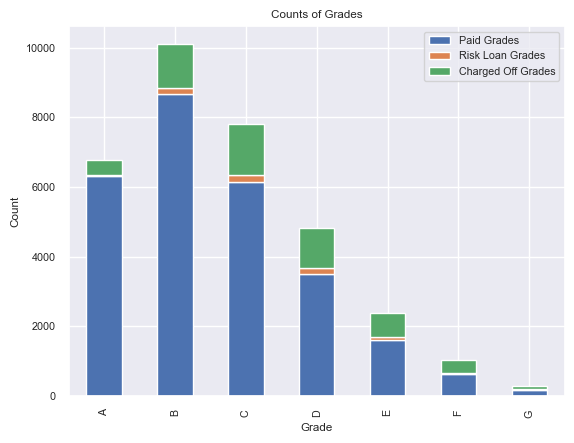

In [59]:
data = {'Paid Grades': paid_loans['grade'].value_counts(),
        # 'On Time Grades': on_time_loans['grade'].value_counts(),
        # 'Grace Period Grades': grace_period_loans['grade'].value_counts(),
        'Risk Loan Grades': risk_loans['grade'].value_counts(),
        'Charged Off Grades': charged_off_loans['grade'].value_counts()
        }

df = pd.DataFrame(data)

for index, row in df.iterrows():
    print(f"Paid Loans {index} Grade: {row['Paid Grades']}")
    # print(f"On time {index} Grades: {row['On Time Grades']}")
    # print(f"Grace Period {index} Grades: {row['Grace Period Grades']}")
    print(f"Risk Loan {index} Grades: {row['Risk Loan Grades']}")
    print(f"Charged Off Loan {index} Grades: {row['Charged Off Grades']}") 

df.plot(kind='bar', stacked=True)

plt.title('Counts of Grades')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend()
# Displaying the plot
plt.show()

Paid Loans sub grade A1: 750
Risk Loan sub grade A1: 2
Charged Off Loan sub grade A1: 10
Paid Loans sub grade A2: 959
Risk Loan sub grade A2: 1
Charged Off Loan sub grade A2: 50
Paid Loans sub grade A3: 1155
Risk Loan sub grade A3: 2
Charged Off Loan sub grade A3: 71
Paid Loans sub grade A4: 1767
Risk Loan sub grade A4: 6
Charged Off Loan sub grade A4: 136
Paid Loans sub grade A5: 1687
Risk Loan sub grade A5: 16
Charged Off Loan sub grade A5: 155
Paid Loans sub grade B1: 1557
Risk Loan sub grade B1: 26
Charged Off Loan sub grade B1: 165
Paid Loans sub grade B2: 1700
Risk Loan sub grade B2: 27
Charged Off Loan sub grade B2: 234
Paid Loans sub grade B3: 1922
Risk Loan sub grade B3: 29
Charged Off Loan sub grade B3: 277
Paid Loans sub grade B4: 1811
Risk Loan sub grade B4: 56
Charged Off Loan sub grade B4: 304
Paid Loans sub grade B5: 1667
Risk Loan sub grade B5: 35
Charged Off Loan sub grade B5: 300
Paid Loans sub grade C1: 1475
Risk Loan sub grade C1: 39
Charged Off Loan sub grade C1: 3

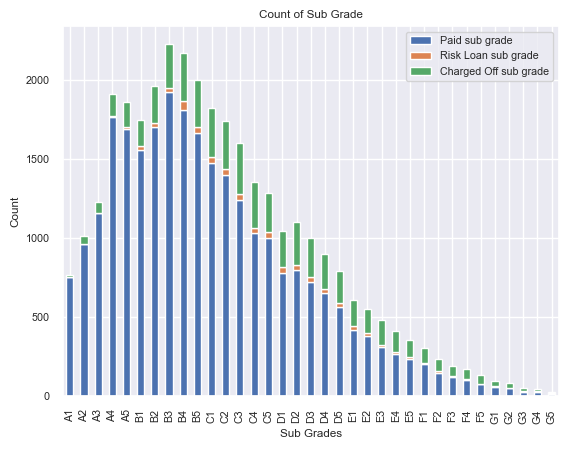

In [60]:
data = {'Paid sub grade': paid_loans['sub_grade'].value_counts(),
        # 'On Time sub grade': on_time_loans['sub_grade'].value_counts(),
        # 'Grace Period sub grade': grace_period_loans['sub_grade'].value_counts(),
        'Risk Loan sub grade': risk_loans['sub_grade'].value_counts(),
        'Charged Off sub grade': charged_off_loans['sub_grade'].value_counts()
        }

df = pd.DataFrame(data)

for index, row in df.iterrows():
    print(f"Paid Loans sub grade {index}: {row['Paid sub grade']}")
    # print(f"On time sub grade {index}: {row['On Time sub grade']}")
    # print(f"Grace Period sub grade {index}: {row['Grace Period sub grade']}")
    print(f"Risk Loan sub grade {index}: {row['Risk Loan sub grade']}")
    print(f"Charged Off Loan sub grade {index}: {row['Charged Off sub grade']}")

df = pd.DataFrame(data)

df.plot(kind='bar', stacked=True)

plt.title('Count of Sub Grade')
plt.xlabel('Sub Grades')
plt.ylabel('Count')
plt.legend()
plt.show()

Paid Loans purpose: car 698.0
Risk Loan purpose: car 5.0
Charged Off Loan purpose: car 89.0
Paid Loans purpose: credit_card 4949.0
Risk Loan purpose: credit_card 140.0
Charged Off Loan purpose: credit_card 874.0
Paid Loans purpose: debt_consolidation 14095.0
Risk Loan purpose: debt_consolidation 431.0
Charged Off Loan purpose: debt_consolidation 3045.0
Paid Loans purpose: educational 130.0
Risk Loan purpose: educational nan
Charged Off Loan purpose: educational 26.0
Paid Loans purpose: home_improvement 1795.0
Risk Loan purpose: home_improvement 36.0
Charged Off Loan purpose: home_improvement 267.0
Paid Loans purpose: house 210.0
Risk Loan purpose: house 2.0
Charged Off Loan purpose: house 38.0
Paid Loans purpose: major_purchase 1104.0
Risk Loan purpose: major_purchase 7.0
Charged Off Loan purpose: major_purchase 165.0
Paid Loans purpose: medical 366.0
Risk Loan purpose: medical 5.0
Charged Off Loan purpose: medical 79.0
Paid Loans purpose: moving 278.0
Risk Loan purpose: moving 5.0
Cha

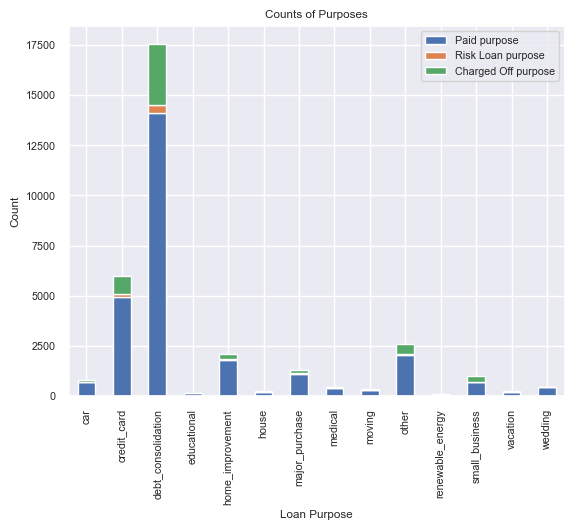

In [61]:
data = {'Paid purpose': paid_loans['purpose'].value_counts(),
        # 'On Time purpose': on_time_loans['purpose'].value_counts(),
        # 'Grace Period purpose': grace_period_loans['purpose'].value_counts(),
        'Risk Loan purpose': risk_loans['purpose'].value_counts(),
        'Charged Off purpose': charged_off_loans['purpose'].value_counts()
        }

df = pd.DataFrame(data)

for index, row in df.iterrows():
    print(f"Paid Loans purpose: {index} {row['Paid purpose']}")
    # print(f"On time purpose: {index} {row['On Time purpose']}")
    # print(f"Grace Period purpose: {index} {row['Grace Period purpose']}")
    print(f"Risk Loan purpose: {index} {row['Risk Loan purpose']}")
    print(f"Charged Off Loan purpose: {index} {row['Charged Off purpose']}")

df.plot(kind='bar', stacked=True)

plt.title('Counts of Purposes')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.legend()
plt.show()

Paid Loans home ownership: MORTGAGE 13174.0
Risk Loan home ownership: MORTGAGE 307.0
Charged Off Loan home ownership: MORTGAGE 2424.0
Paid Loans home ownership: NONE 1.0
Risk Loan home ownership: NONE nan
Charged Off Loan home ownership: NONE nan
Paid Loans home ownership: OTHER 35.0
Risk Loan home ownership: OTHER nan
Charged Off Loan home ownership: OTHER 9.0
Paid Loans home ownership: OWN 2191.0
Risk Loan home ownership: OWN 70.0
Charged Off Loan home ownership: OWN 509.0
Paid Loans home ownership: RENT 11632.0
Risk Loan home ownership: RENT 309.0
Charged Off Loan home ownership: RENT 2561.0


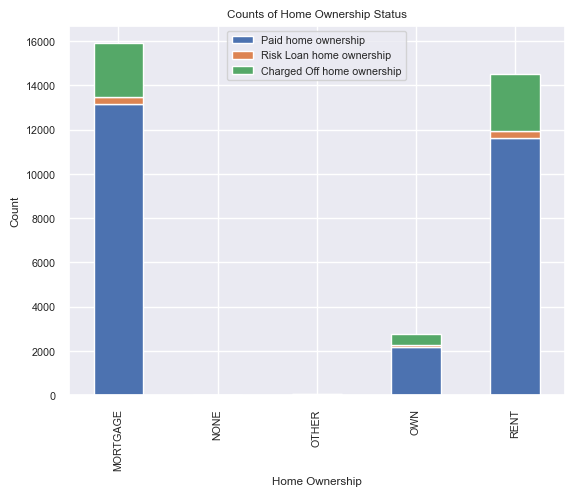

In [62]:
data = {'Paid home ownership': paid_loans['home_ownership'].value_counts(),
    # 'On Time home ownership': on_time_loans['home_ownership'].value_counts(),
    # 'Grace Period home ownership': grace_period_loans['home_ownership'].value_counts(),
    'Risk Loan home ownership': risk_loans['home_ownership'].value_counts(),
    'Charged Off home ownership': charged_off_loans['home_ownership'].value_counts()
    }
df = pd.DataFrame(data)

for index, row in df.iterrows():
    print(f"Paid Loans home ownership: {index} {row['Paid home ownership']}")
    # print(f"On time home ownership: {index} {row['On Time home ownership']}")
    # print(f"Grace Period home ownership: {index} {row['Grace Period home ownership']}")
    print(f"Risk Loan home ownership: {index} {row['Risk Loan home ownership']}")
    print(f"Charged Off Loan home ownership: {index} {row['Charged Off home ownership']}")

df.plot(kind='bar', stacked=True)

plt.title('Counts of Home Ownership Status')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.legend()
plt.show()

Paid Loans employment length 0: 789
Risk Loan employment length 0: 39
Charged Off Loan employment length 0: 269
Paid Loans employment length 1 year: 1973
Risk Loan employment length 1 year: 36
Charged Off Loan employment length 1 year: 362
Paid Loans employment length 10+ years: 7199
Risk Loan employment length 10+ years: 225
Charged Off Loan employment length 10+ years: 1535
Paid Loans employment length 2 years: 2745
Risk Loan employment length 2 years: 66
Charged Off Loan employment length 2 years: 510
Paid Loans employment length 3 years: 2473
Risk Loan employment length 3 years: 44
Charged Off Loan employment length 3 years: 501
Paid Loans employment length 4 years: 1966
Risk Loan employment length 4 years: 34
Charged Off Loan employment length 4 years: 335
Paid Loans employment length 5 years: 2019
Risk Loan employment length 5 years: 40
Charged Off Loan employment length 5 years: 418
Paid Loans employment length 6 years: 1557
Risk Loan employment length 6 years: 37
Charged Off Lo

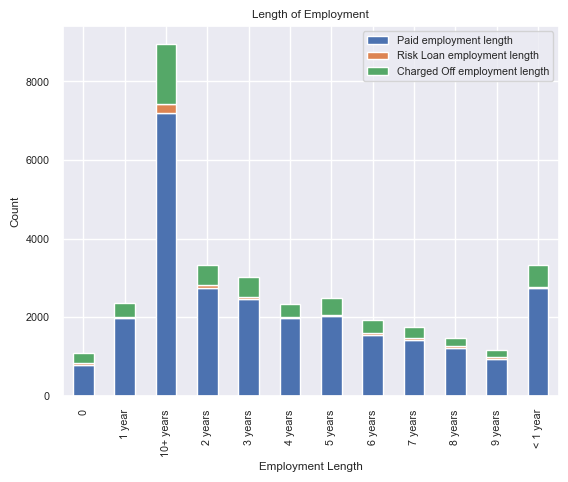

In [63]:
data = {'Paid employment length': paid_loans['employment_length'].value_counts(),
    # 'On Time employment length': on_time_loans['employment_length'].value_counts(),
    # 'Grace Period employment length': grace_period_loans['employment_length'].value_counts(),
    'Risk Loan employment length': risk_loans['employment_length'].value_counts(),
    'Charged Off employment length': charged_off_loans['employment_length'].value_counts()
    }

df = pd.DataFrame(data)

for index, row in df.iterrows():
    print(f"Paid Loans employment length {index}: {row['Paid employment length']}")
    # print(f"On time employment length {index}: {row['On Time employment length']}")
    # print(f"Grace Period employment length {index}: {row['Grace Period employment length']}")
    print(f"Risk Loan employment length {index}: {row['Risk Loan employment length']}")
    print(f"Charged Off Loan employment length {index}: {row['Charged Off employment length']}")

df.plot(kind='bar', stacked=True)

plt.title('Length of Employment')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.legend()
plt.show()

Paid annual income counts:
Paid annual income
60000.0    1002
50000.0     824
65000.0     688
75000.0     658
40000.0     622
           ... 
66400.0       1
35630.0       1
90455.0       1
98325.0       1
27376.0       1
Name: count, Length: 3688, dtype: int64

Risk Loan annual income counts:
Risk Loan annual income
60000.0     34
55000.0     27
50000.0     23
75000.0     22
45000.0     22
            ..
62995.0      1
87000.0      1
38516.0      1
104000.0     1
124800.0     1
Name: count, Length: 222, dtype: int64

Charged Off annual income counts:
Charged Off annual income
60000.0     255
50000.0     199
40000.0     154
45000.0     153
65000.0     140
           ... 
69993.0       1
40882.0       1
164000.0      1
62955.0       1
33990.0       1
Name: count, Length: 1097, dtype: int64



/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


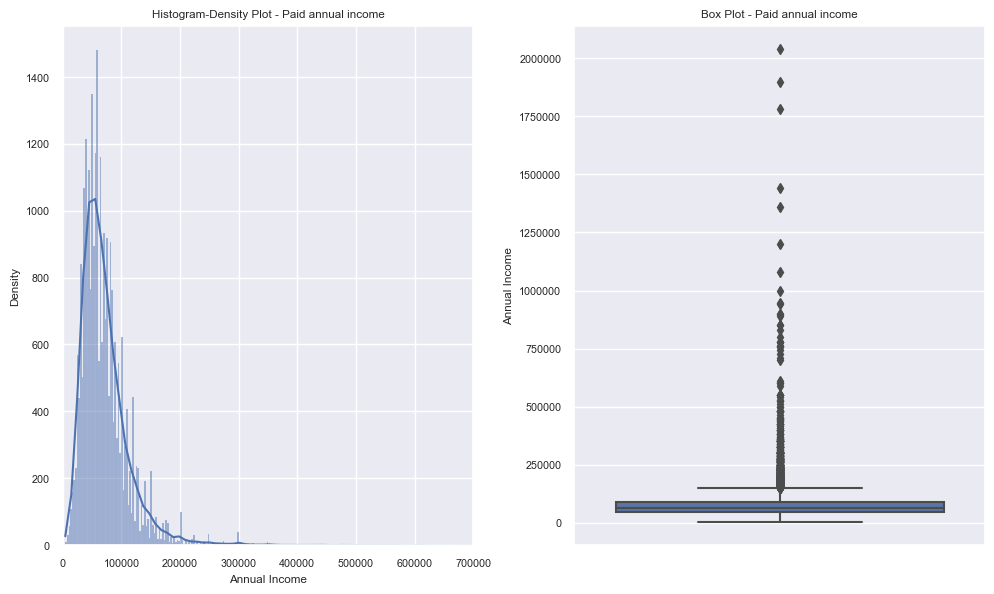

/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


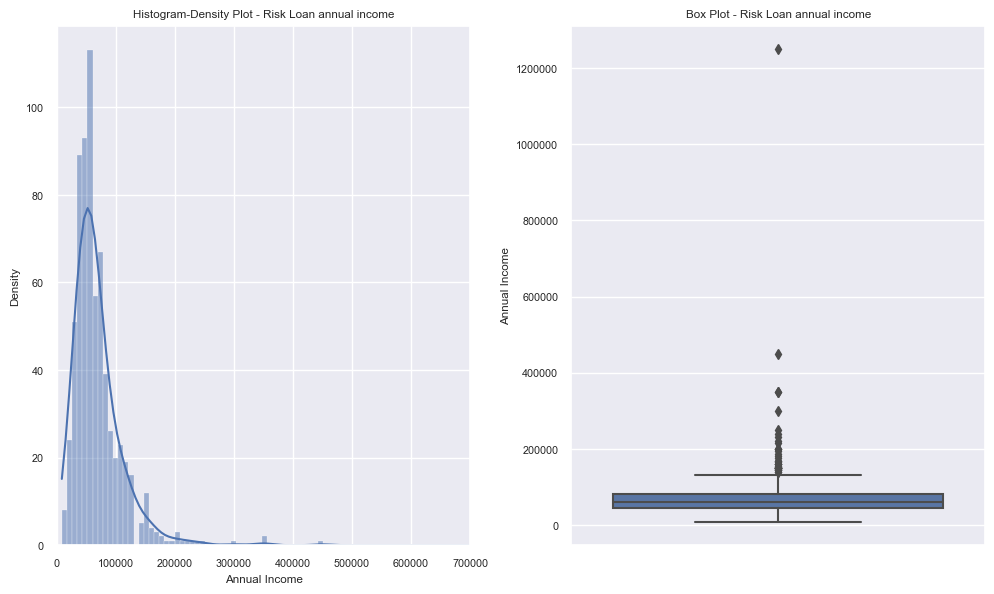

/Users/joeybest/miniconda/envs/eda2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


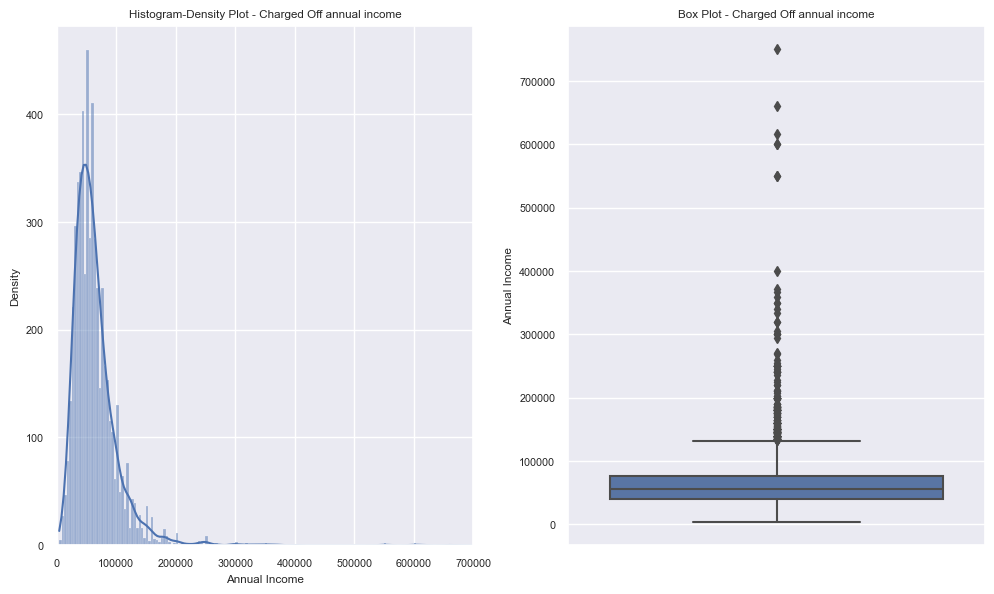

In [64]:
data = {
'Paid annual income': paid_loans['annual_inc'],
'Risk Loan annual income': risk_loans['annual_inc'],
'Charged Off annual income': charged_off_loans['annual_inc']
}

df = pd.DataFrame(data)

# Print the counts for each loan category
for column in df.columns:
    counts = df[column].value_counts()
    print(f"{column} counts:")
    print(counts)
    print()

# Plotting histogram-density plots using seaborn
for column in df.columns:
    plt.figure(figsize=(10, 6))  # Set the figure size as needed
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f"Histogram-Density Plot - {column}")
    plt.xlabel("Annual Income")
    plt.ylabel("Density")
    plt.xlim(0, 700000)  # Adjust the x-axis limits as needed

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column])
    plt.title(f"Box Plot - {column}")
    plt.ylabel("Annual Income")

    # Customising y-axis tick labels
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()

#### Different views of boxplots for annual_inc


Paid Loans annual income 4080: nan
Risk Loan annual income 4080: nan
Charged Off Loan annual income 4080: 1.0
Paid Loans annual income 4200: 1.0
Risk Loan annual income 4200: nan
Charged Off Loan annual income 4200: nan
Paid Loans annual income 4800: 2.0
Risk Loan annual income 4800: nan
Charged Off Loan annual income 4800: 1.0
Paid Loans annual income 4888: 1.0
Risk Loan annual income 4888: nan
Charged Off Loan annual income 4888: nan
Paid Loans annual income 5000: 1.0
Risk Loan annual income 5000: nan
Charged Off Loan annual income 5000: nan
Paid Loans annual income 5500: 1.0
Risk Loan annual income 5500: nan
Charged Off Loan annual income 5500: nan
Paid Loans annual income 6000: 3.0
Risk Loan annual income 6000: nan
Charged Off Loan annual income 6000: 2.0
Paid Loans annual income 7200: 1.0
Risk Loan annual income 7200: nan
Charged Off Loan annual income 7200: nan
Paid Loans annual income 7500: 1.0
Risk Loan annual income 7500: nan
Charged Off Loan annual income 7500: nan
Paid Loans

(array([1, 2, 3]),
 [Text(1, 0, 'Paid annual income'),
  Text(2, 0, 'Risk Loan annual income'),
  Text(3, 0, 'Charged Off annual income')])

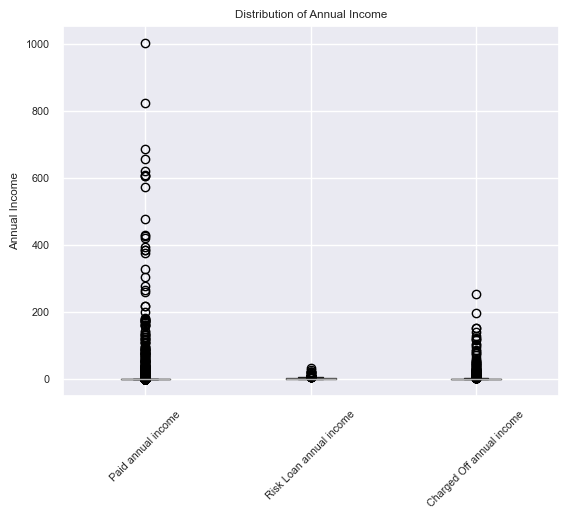

In [65]:
data = {'Paid annual income': paid_loans['annual_inc'].value_counts(),
        # 'On Time annual income': on_time_loans['annual_inc'].value_counts(),
        # 'Grace Period annual income': grace_period_loans['annual_inc'].value_counts(),
        'Risk Loan annual income': risk_loans['annual_inc'].value_counts(),
        'Charged Off annual income': charged_off_loans['annual_inc'].value_counts()
        }

df = pd.DataFrame(data)

for index, row in df.iterrows():
    print(f"Paid Loans annual income {index}: {row['Paid annual income']}")
    # print(f"On time annual income {index}: {row['On Time annual income']}")
    # print(f"Grace Period annual income {index}: {row['Grace Period annual income']}")
    print(f"Risk Loan annual income {index}: {row['Risk Loan annual income']}")
    print(f"Charged Off Loan annual income {index}: {row['Charged Off annual income']}")

df = pd.DataFrame(data)

# Plotting the box plot
df.boxplot()
plt.title('Distribution of Annual Income')
plt.ylabel('Annual Income')
plt.xticks(rotation=45)

Paid annual income counts:
Paid annual income
60000.0    1002
50000.0     824
65000.0     688
75000.0     658
40000.0     622
           ... 
66400.0       1
35630.0       1
90455.0       1
98325.0       1
27376.0       1
Name: count, Length: 3688, dtype: int64

Risk Loan annual income counts:
Risk Loan annual income
60000.0     34
55000.0     27
50000.0     23
75000.0     22
45000.0     22
            ..
62995.0      1
87000.0      1
38516.0      1
104000.0     1
124800.0     1
Name: count, Length: 222, dtype: int64

Charged Off annual income counts:
Charged Off annual income
60000.0     255
50000.0     199
40000.0     154
45000.0     153
65000.0     140
           ... 
69993.0       1
40882.0       1
164000.0      1
62955.0       1
33990.0       1
Name: count, Length: 1097, dtype: int64



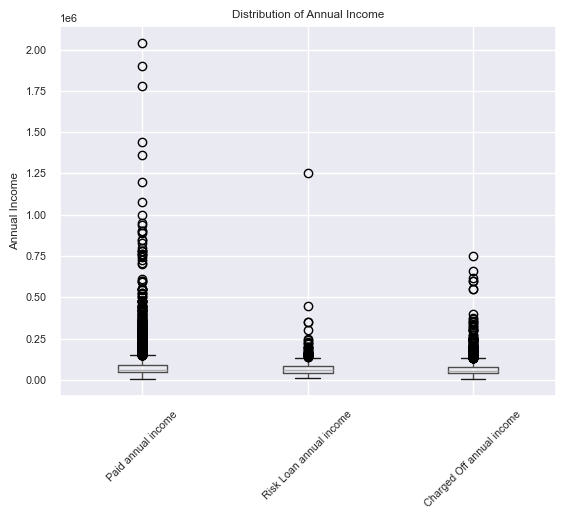

In [66]:
data = {
    'Paid annual income': paid_loans['annual_inc'],
    'Risk Loan annual income': risk_loans['annual_inc'],
    'Charged Off annual income': charged_off_loans['annual_inc']
}

df = pd.DataFrame(data)

# Print the counts for each loan category
for column in df.columns:
    counts = df[column].value_counts()
    print(f"{column} counts:")
    print(counts)
    print()

df.boxplot()

# Customizing the plot
plt.title('Distribution of Annual Income')
plt.ylabel('Annual Income')
plt.xticks(rotation=45)

plt.show()

# Summary

## Grade / Sub Grade:
- Those with a higher Grade or Sub grade were more likely to pay back the full loan, than those with lower grades

- As the grade decends from 'A', there is a decrease in fully paid loans and an increase in risk and charged off loans between 'B1-E2'

- Thus, the lower the grade the more risky the loan becomes


## Annual Income:

- In comparison to the paid loans, charged off and risk loans are drastically smaller

- Thus indicating that a higher income is suggestive of being able to pay the full loan back

- Smaller annual incomes are suggestive of needing more time/assistance or likely to be charged off 


## Purpose:
- debt_consolidation Has a significant increase within the risk and charged off loans as a the primary/majority purpose for their loans

    - The majority of paid loans was for this purpose too

- Meaning purpose alone may not directly be linked to likelyhood to be able to pay back the loans, an analysis of all indicators would need to be observed

- Small businesses and credit_card purposes also poses a strong likelyhood of being charged off

## Home Ownership:
- Morgage owners are very likely to be able to pay the full loan

- Renters are slightly more likely to be charged off, but still hold a good place for repaying their loans in full

- However, people who own their property seem to be not as likely as the previous two to pay the loan in full

    - But there is less data on that point

- So in summary people who rent their property should be accepted with some caution

## Employment Length:
- The largest amount of paid, charged off and risk loans all come frome people who have been in employment for 10 years+

    - Paid loans are significantly higher, suggesting that people in long term employment are more likely to pay their loans in full

- However, ignoring the 10years+ most of the columns seem largely similar

- This could suggest that employment length doesnt have a significant impact on ability to repay loans

    - But it should still be noted that people who have worked less than a year have the 2nd largest amount of charged off loans after the 10years+
